In [1]:
import pandas as pd


bugs_train_df = pd.read_csv("datasets/bugs-train.csv", encoding='ISO-8859-1')
bugs_test_df = pd.read_csv("datasets/bugs-test.csv", encoding='ISO-8859-1')

print(bugs_train_df.head())
print(bugs_test_df.head())


   bug id                                            summary  severity
0  365569                  Remove workaround from bug 297227    normal
1  365578    Print Preview crashes on any URL in gtk2 builds  critical
2  365582                     Lines are not showing in table     major
3  365584  Firefox render ÂÃÃsimplified ArabicÂÃÂ f...    normal
4  365597             Crash [@ nsINodeInfo::NodeInfoManager]  critical
    bug id                                            summary
0  1143402  Firefox claims to be not the default browser w...
1  1143405  Background of html and body element are not ap...
2  1143409  Mouse input breaks after using window.showModa...
3  1143411  Build failure with next freetype version/curre...
4  1143417  HTML element is not treated as root inside for...


In [2]:
bugs_train_df.info 


<bound method DataFrame.info of          bug id                                            summary  severity
0        365569                  Remove workaround from bug 297227    normal
1        365578    Print Preview crashes on any URL in gtk2 builds  critical
2        365582                     Lines are not showing in table     major
3        365584  Firefox render ÂÃÃsimplified ArabicÂÃÂ f...    normal
4        365597             Crash [@ nsINodeInfo::NodeInfoManager]  critical
...         ...                                                ...       ...
159993  1143381  block elements with height after float left or...    normal
159994  1143392  typing in google translate will send reset inp...    normal
159995  1143394  [gstreamer] Nightly instantly crashes on Youtu...  critical
159996  1143395  Right click on Flash object with accessibility...  critical
159997  1143398  OSX Javascript new Date() initialized with Sta...    normal

[159998 rows x 3 columns]>

In [3]:
bugs_test_df.info

<bound method DataFrame.info of         bug id                                            summary
0      1143402  Firefox claims to be not the default browser w...
1      1143405  Background of html and body element are not ap...
2      1143409  Mouse input breaks after using window.showModa...
3      1143411  Build failure with next freetype version/curre...
4      1143417  HTML element is not treated as root inside for...
...        ...                                                ...
86089  1426166      Crash in bool IsAboutToBeFinalizedInternal<T>
86090  1426171  Potential crash if GraphRate is greater than 4...
86091  1426173  Crash in <name omitted> | decltype JS::Dispatc...
86092  1426174  Crash in xul.dll@0x28145fa | xul.dll@0x3c748ff...
86093  1426176  No symbols for clang_rt.asan_dynamic-x86_64.dl...

[86094 rows x 2 columns]>

Encode the labels to use with xgboost.

In [4]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
bugs_train_df['severity_encoded'] = label_encoder.fit_transform(bugs_train_df['severity'])

# Print encoding correspondence
encoding_correspondence = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Encoding Correspondence:", encoding_correspondence)


Encoding Correspondence: {'blocker': 0, 'critical': 1, 'enhancement': 2, 'major': 3, 'minor': 4, 'normal': 5, 'trivial': 6}


PREPROCESS THE TEXT DATA:

In [5]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nltk
nltk.download('stopwords')


import string

def remove_punctuation(text):
    punctuation_pattern = re.compile('[%s]' % re.escape(string.punctuation))
   
    text_without_punctuation = punctuation_pattern.sub(' ', text)
    return text_without_punctuation

def preprocess_text(text):
   
    text = re.sub(r'<', ' ', text)
    text = re.sub(r'>', ' ', text)
    text = re.sub(r'_', ' ', text)
    text = re.sub(r'\[', ' ', text)
    text = re.sub(r'\(', ' ', text)
    text = re.sub(r'\]', ' ', text)
    text = re.sub(r'\)', ' ', text)
    text = re.sub(r':', ' ', text)
    text = re.sub(r'\.', ' ', text)
    text = re.sub(r'@', ' @ ', text)
    #text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)  #  non-alphanumeric characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # non-ASCII characters
    text = re.sub(r'#', ' # ', text) 
    #text = remove_punctuation(text)


    
    text = text.lower()
   
    text = re.sub(r'\d+', ' ', text)
   
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

sample_text = "Crash [@ nsINodeInfo::NodeInfoManager] #example <html> .content 123 testing"
cleaned_text = preprocess_text(sample_text)
print(cleaned_text)


crash @ nsinodeinfo nodeinfomanag # exampl html content test


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\idilk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We will use tfidf vectors, but first, we will preprocess the text data and put it into the dataframe as a seperate column and split it into training ad validation sets.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
text_data = bugs_train_df["summary"]
processed_text_data = text_data.apply(preprocess_text)
text_data = processed_text_data
print(text_data)

0                                      remov workaround bug
1                         print preview crash url gtk build
2                                            line show tabl
3         firefox render simplifi arab font face incorre...
4                         crash @ nsinodeinfo nodeinfomanag
                                ...                        
159993    block element height float left right corrupt ...
159994    type googl translat send reset input method linux
159995    gstreamer nightli instantli crash youtub linux...
159996    right click flash object access activ crash pl...
159997    osx javascript new date initi standard timezon...
Name: summary, Length: 159998, dtype: object


In [8]:
bugs_train_df["summary_preprocessed"] = text_data
print(bugs_train_df.head())

   bug id                                            summary  severity  \
0  365569                  Remove workaround from bug 297227    normal   
1  365578    Print Preview crashes on any URL in gtk2 builds  critical   
2  365582                     Lines are not showing in table     major   
3  365584  Firefox render ÂÃÃsimplified ArabicÂÃÂ f...    normal   
4  365597             Crash [@ nsINodeInfo::NodeInfoManager]  critical   

   severity_encoded                               summary_preprocessed  
0                 5                               remov workaround bug  
1                 1                  print preview crash url gtk build  
2                 3                                     line show tabl  
3                 5  firefox render simplifi arab font face incorre...  
4                 1                  crash @ nsinodeinfo nodeinfomanag  


All training data is preprocessed. Now we can split.

In [9]:
from sklearn.model_selection import train_test_split
X = bugs_train_df.drop(columns=["summary", "severity", "severity_encoded"]) #use the bugID as feature as well? 
y = bugs_train_df["severity_encoded"]

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=True)

print(X_train)
print(X_val)

         bug id                               summary_preprocessed
138894  1031097  android aw content/canvas/test/webgl-conforman...
115279   912304  differenti test differ output messag involv de...
129928   981261      renam nseventlistener* mozilla eventlistener*
74987    725570  intermitt test bug html | finish non-clean fas...
36702    545093       result geo locat use document open mani time
...         ...                                                ...
119879   932701  keep prioriti & nice valu thread relat media p...
103694   856630  creat frame bit remain frame list properti mak...
131932   991067  cost control crash ftu step mozilla gfx getcai...
146867  1075670                e event screenx event screeni wrong
121958   942049     need better job interrupt long-run reflow pass

[127998 rows x 2 columns]
        bug id                               summary_preprocessed
49889   603205        print page footer place somewher middl page
32693   523688  spuriou oom messag re

In [10]:
print("Distribution of labels in y_train:")
print(y_train.value_counts())

Distribution of labels in y_train:
severity_encoded
5    100534
1     14995
3      4852
2      3574
4      2509
6       976
0       558
Name: count, dtype: int64


severity_encoded
5    78.543415
1    11.715027
3     3.790684
2     2.792231
4     1.960187
6     0.762512
0     0.435944
Name: count, dtype: float64


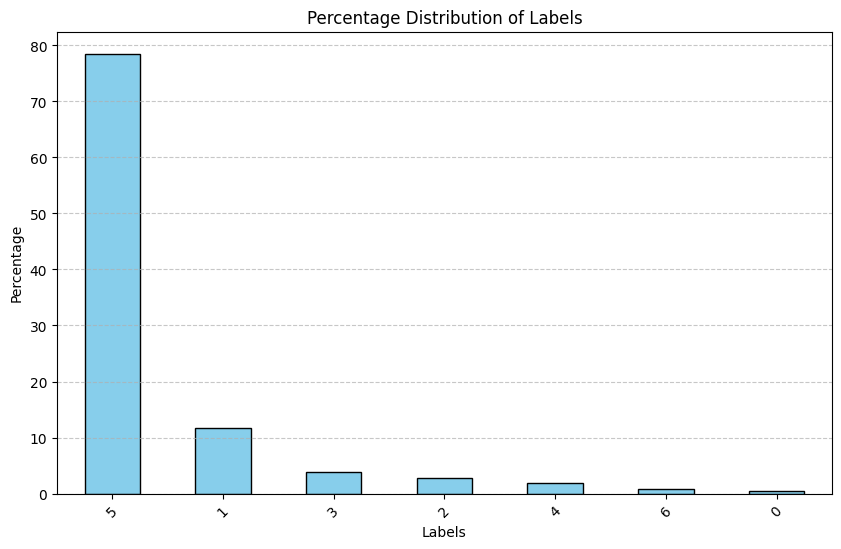

In [14]:
import matplotlib.pyplot as plt
label_counts = y_train.value_counts()

total_samples = len(y_train)
label_percentages = (label_counts / total_samples) * 100

print(label_percentages)

plt.figure(figsize=(10, 6))
label_percentages.plot(kind='bar', color='skyblue', edgecolor='k')
plt.title('Percentage Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Is this realistic? It can be. 

Fit tfidf to the training set and then transform training and validation sets. 

In [15]:

tfidf_vectorizer = TfidfVectorizer(min_df=30, max_df=0.8)
text_data = X_train ["summary_preprocessed"]

X_train_tfidf = tfidf_vectorizer.fit_transform(text_data)

df_tfidf = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf, columns=tfidf_vectorizer.get_feature_names_out())

print(df_tfidf)


        aa  aac  ab  abi  abil  abl  abort  about  absolut  absolute  ...  \
0        0    0   0    0     0    0      0      0        0         0  ...   
1        0    0   0    0     0    0      0      0        0         0  ...   
2        0    0   0    0     0    0      0      0        0         0  ...   
3        0    0   0    0     0    0      0      0        0         0  ...   
4        0    0   0    0     0    0      0      0        0         0  ...   
...     ..  ...  ..  ...   ...  ...    ...    ...      ...       ...  ...   
127993   0    0   0    0     0    0      0      0        0         0  ...   
127994   0    0   0    0     0    0      0      0        0         0  ...   
127995   0    0   0    0     0    0      0      0        0         0  ...   
127996   0    0   0    0     0    0      0      0        0         0  ...   
127997   0    0   0    0     0    0      0      0        0         0  ...   

        yosemit  youtub  zdi  zero  zimbra  zip  zlib  zombi  zone  zoom  


In [16]:

text_data = X_val["summary_preprocessed"]
processed_text_data = text_data.apply(preprocess_text)
text_data = processed_text_data

X_tfidf_val= tfidf_vectorizer.transform(text_data)

df_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf_val, columns=tfidf_vectorizer.get_feature_names_out())

print(df_tfidf)


       aa  aac  ab  abi  abil  abl  abort  about  absolut  absolute  ...  \
0       0    0   0    0     0    0      0      0        0         0  ...   
1       0    0   0    0     0    0      0      0        0         0  ...   
2       0    0   0    0     0    0      0      0        0         0  ...   
3       0    0   0    0     0    0      0      0        0         0  ...   
4       0    0   0    0     0    0      0      0        0         0  ...   
...    ..  ...  ..  ...   ...  ...    ...    ...      ...       ...  ...   
31995   0    0   0    0     0    0      0      0        0         0  ...   
31996   0    0   0    0     0    0      0      0        0         0  ...   
31997   0    0   0    0     0    0      0      0        0         0  ...   
31998   0    0   0    0     0    0      0      0        0         0  ...   
31999   0    0   0    0     0    0      0      0        0         0  ...   

       yosemit  youtub  zdi  zero  zimbra       zip  zlib  zombi  zone  zoom  
0       

We want to build an ensemble model of ensemble models, we now try different models and see if they perform well on validaiton set. 

In [17]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

X = X_train_tfidf 
y =y_train 


XGBOOST MODEL without the class weights. 

In [18]:
import xgboost as xgb


params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 750,
    'subsample': 0.8
}


xgb_model = xgb.XGBClassifier(
    colsample_bytree=params['colsample_bytree'],
    learning_rate=params['learning_rate'],
    max_depth=params['max_depth'],
    n_estimators=params['n_estimators'],
    subsample=params['subsample'],

)


In [19]:
xgb_model.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=750, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, classification_report, roc_curve, auc, roc_auc_score

y_pred_xg = xgb_model.predict(X_tfidf_val)

macro_precision = precision_score(y_val, y_pred_xg, average='macro')
print(f'Macro Precision Score: {macro_precision:.4f}')

print(classification_report(y_val, y_pred_xg))


Macro Precision Score: 0.7741
              precision    recall  f1-score   support

           0       0.50      0.01      0.01       143
           1       0.77      0.77      0.77      3663
           2       1.00      0.01      0.01       852
           3       0.78      0.03      0.05      1201
           4       1.00      0.01      0.01       593
           5       0.87      0.97      0.92     25320
           6       0.50      0.00      0.01       228

    accuracy                           0.86     32000
   macro avg       0.77      0.26      0.26     32000
weighted avg       0.86      0.86      0.82     32000



The precision for classes 2,4 arevery good but it performs badly for 0 and 6. Since 0 and 6 had the lowest number of examples on the training set, we may try to fix that by using class weigths. 

In [21]:
import xgboost as xgb


params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 500,
    'subsample': 0.8
}

xgb_model_2 = xgb.XGBClassifier(
    colsample_bytree=params['colsample_bytree'],
    learning_rate=params['learning_rate'],
    max_depth=params['max_depth'],
    n_estimators=params['n_estimators'],
    subsample=params['subsample'],
 
)


xgboost takes class weights as array!

The class weights are somewhat proportinallty adjusted. The normal class (5)'s weight is adjusted to our intuition that normal label should appear more than others.

In [22]:
from sklearn.model_selection import train_test_split
import numpy as np

class_weights={0: 1, 1:3, 2:1, 3:1, 4:1, 5:4, 6:1 }
sample_weights = np.array([class_weights[class_label] for class_label in y])
xgb_model_2.fit(X,y, sample_weight= sample_weights )


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [23]:

y_pred_xg_2 = xgb_model_2.predict(X_tfidf_val)
macro_precision = precision_score(y_val, y_pred_xg_2, average='macro')
print(f'Macro Precision Score: {macro_precision:.4f}')
print(classification_report(y_val, y_pred_xg_2))


Macro Precision Score: 0.7153
              precision    recall  f1-score   support

           0       0.50      0.01      0.01       143
           1       0.77      0.76      0.77      3663
           2       1.00      0.01      0.01       852
           3       0.87      0.01      0.02      1201
           4       0.00      0.00      0.00       593
           5       0.87      0.97      0.92     25320
           6       1.00      0.00      0.01       228

    accuracy                           0.86     32000
   macro avg       0.72      0.25      0.25     32000
weighted avg       0.84      0.86      0.82     32000



C:\Users\idilk\OneDrive\Masaüstü\cs412_kaggle\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\idilk\OneDrive\Masaüstü\cs412_kaggle\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\idilk\OneDrive\Masaüstü\cs412_kaggle\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Now the precision for classes 1 and 2 are %100. But our model can't classify the class 4.

Another model we can try is logistic regression. We will try and see if we can achieve different scores on macro precision when the cclass labels are adjusted. The max_iter is adjusted until if we could reach a %70+ macro precision. 

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


class_weight_lr1 = {0: 3, 1: 5, 2:2, 3:1, 4:1, 5:4, 6:5}  


log_reg_model = LogisticRegression(class_weight=class_weight_lr1, random_state=42, max_iter= 70)

log_reg_model.fit(X, y)

y_pred_lr = log_reg_model.predict(X_tfidf_val)
print(classification_report(y_val, y_pred_lr))

macro_precision = precision_score(y_val, y_pred_lr , average='macro')
print(f'Macro Precision Score: {macro_precision:.4f}')

              precision    recall  f1-score   support

           0       0.33      0.02      0.04       143
           1       0.77      0.73      0.75      3663
           2       0.77      0.01      0.02       852
           3       0.85      0.01      0.03      1201
           4       1.00      0.00      0.01       593
           5       0.87      0.97      0.92     25320
           6       0.35      0.04      0.06       228

    accuracy                           0.85     32000
   macro avg       0.70      0.25      0.26     32000
weighted avg       0.85      0.85      0.81     32000

Macro Precision Score: 0.7047


C:\Users\idilk\OneDrive\Masaüstü\cs412_kaggle\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


class_weight_lr2 = {0: 4, 1: 5, 2:2, 3:1, 4:1, 5:1, 6:8}  
class_weight_lr2[5] = 4 


log_reg_model_2= LogisticRegression(class_weight=class_weight_lr2, random_state=42, max_iter= 200)

log_reg_model_2.fit(X, y)

# Evaluate the stacking model
y_pred_lr_2= log_reg_model_2.predict(X_tfidf_val)
print(classification_report(y_val, y_pred_lr_2))

macro_precision = precision_score(y_val, y_pred_lr_2 , average='macro')
print(f'Macro Precision Score: {macro_precision:.4f}')

              precision    recall  f1-score   support

           0       0.36      0.03      0.05       143
           1       0.77      0.73      0.75      3663
           2       0.83      0.01      0.02       852
           3       0.90      0.01      0.03      1201
           4       1.00      0.00      0.00       593
           5       0.87      0.97      0.92     25320
           6       0.25      0.06      0.09       228

    accuracy                           0.85     32000
   macro avg       0.71      0.26      0.27     32000
weighted avg       0.85      0.85      0.81     32000

Macro Precision Score: 0.7121


The precision score is better for classes 2,3,5 but worse for class 6. Overall, we can still use this and the model above as weak classifier for our ensemble model. 

To manually, create the ensemble model. We will train a gradient boost model (catboost) with the predictions made by each model.

In [29]:

logreg_pred1 = log_reg_model.predict(X)
logreg_pred2 = log_reg_model_2.predict(X)

xgb_pred1 = xgb_model.predict(X)
xgb_pred2 = xgb_model_2.predict(X)

base_learner_predictions = pd.DataFrame({
    'logreg_pred1': logreg_pred1,
    'logreg_pred2': logreg_pred2,
    'xgb_pred1': xgb_pred1,
    'xgb_pred2': xgb_pred2
})
print(base_learner_predictions)

        logreg_pred1  logreg_pred2  xgb_pred1  xgb_pred2
0                  5             5          5          5
1                  3             3          3          3
2                  5             5          5          5
3                  5             5          5          5
4                  5             5          5          5
...              ...           ...        ...        ...
127993             5             5          5          5
127994             5             5          5          5
127995             1             1          1          1
127996             5             5          5          5
127997             5             5          5          5

[127998 rows x 4 columns]


In [30]:

base_learner_val_predictions = pd.DataFrame({
    'logreg_pred1': y_pred_lr,
    'logreg_pred2': y_pred_lr_2,
    'xgb_pred1': y_pred_xg,
    'xgb_pred2': y_pred_xg_2
})
print(base_learner_val_predictions)

#to use as X of validaiton data.

       logreg_pred1  logreg_pred2  xgb_pred1  xgb_pred2
0                 5             5          5          5
1                 5             5          5          5
2                 5             5          5          5
3                 5             5          5          5
4                 5             5          5          5
...             ...           ...        ...        ...
31995             5             5          5          5
31996             5             5          5          5
31997             5             5          5          5
31998             5             5          5          5
31999             5             5          5          5

[32000 rows x 4 columns]


In [31]:

y_val_for_meta = y_val
y_val_for_meta.reset_index(drop=True, inplace=True)

In [32]:

y_train_for_meta = y_train
y_train_for_meta.reset_index(drop=True, inplace=True)


Now the meta learner will be trained. The class weigths still apply. 

In [35]:
from catboost import CatBoostClassifier


catboost_meta = CatBoostClassifier(iterations=1000,
                          learning_rate=0.005,
                          depth=10,
                          l2_leaf_reg = 2,
                          loss_function = "MultiClass",
                          class_weights = [1,2,1,1,2,4,1]
 
 
                          )

catboost_meta.fit(base_learner_predictions, y_train_for_meta)


0:	learn: 1.9201568	total: 68.9ms	remaining: 1m 8s
1:	learn: 1.8952461	total: 134ms	remaining: 1m 6s
2:	learn: 1.8711299	total: 199ms	remaining: 1m 6s
3:	learn: 1.8477827	total: 231ms	remaining: 57.6s
4:	learn: 1.8251115	total: 269ms	remaining: 53.5s
5:	learn: 1.8031111	total: 304ms	remaining: 50.3s
6:	learn: 1.7819099	total: 324ms	remaining: 46s
7:	learn: 1.7611444	total: 348ms	remaining: 43.2s
8:	learn: 1.7409335	total: 439ms	remaining: 48.4s
9:	learn: 1.7212617	total: 471ms	remaining: 46.6s
10:	learn: 1.7021151	total: 505ms	remaining: 45.4s
11:	learn: 1.6834715	total: 537ms	remaining: 44.2s
12:	learn: 1.6652933	total: 566ms	remaining: 43s
13:	learn: 1.6475546	total: 596ms	remaining: 42s
14:	learn: 1.6302400	total: 629ms	remaining: 41.3s
15:	learn: 1.6133377	total: 663ms	remaining: 40.8s
16:	learn: 1.5968391	total: 696ms	remaining: 40.2s
17:	learn: 1.5807047	total: 734ms	remaining: 40s
18:	learn: 1.5649498	total: 767ms	remaining: 39.6s
19:	learn: 1.5495423	total: 795ms	remaining: 39s

In [69]:
y_pred_cb_stbuild = catboost_meta.predict(base_learner_val_predictions)
print(classification_report(y_val_for_meta, y_pred_cb_stbuild))

macro_precision = precision_score(y_val_for_meta, y_pred_cb_stbuild , average='macro')
print(f'Macro Precision Score: {macro_precision:.4f}')

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       143
           1       0.81      0.68      0.74      3663
           2       1.00      0.01      0.01       852
           3       0.71      0.03      0.06      1201
           4       1.00      0.01      0.01       593
           5       0.86      0.98      0.92     25320
           6       1.00      0.00      0.01       228

    accuracy                           0.86     32000
   macro avg       0.91      0.25      0.25     32000
weighted avg       0.86      0.86      0.81     32000

Macro Precision Score: 0.9111


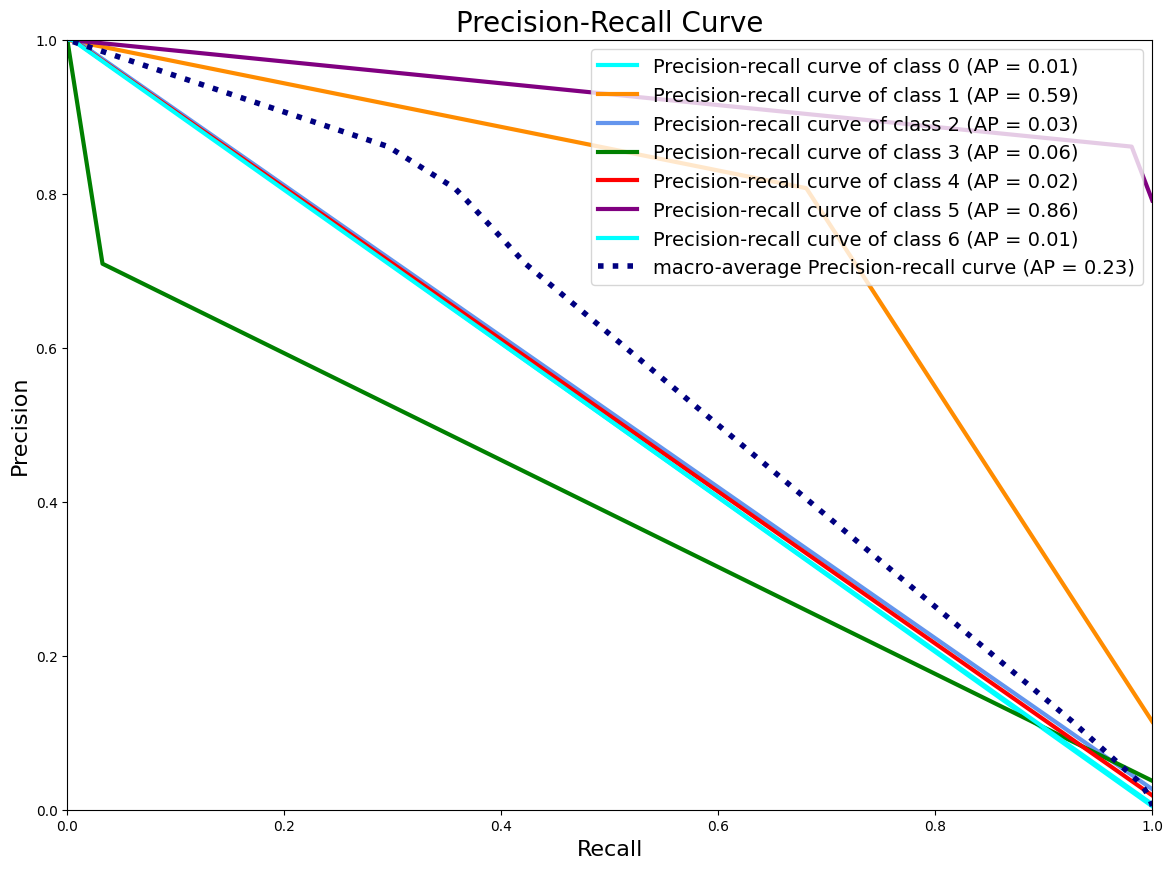

Macro Average Precision (AP) Score: 0.2265


In [74]:
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle


n_classes = len(set(y_val_for_meta))
y_val_bin = label_binarize(y_val_for_meta, classes=range(n_classes))
y_pred_bin = label_binarize(y_pred_cb_stbuild, classes=range(n_classes))

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val_bin[:, i], y_pred_bin[:, i])
    average_precision[i] = average_precision_score(y_val_bin[:, i], y_pred_bin[:, i])

all_precision = np.unique(np.concatenate([precision[i] for i in range(n_classes)]))
mean_recall = np.zeros_like(all_precision)
for i in range(n_classes):
    mean_recall += np.interp(all_precision, precision[i], recall[i])

mean_recall /= n_classes

precision["macro"] = all_precision
recall["macro"] = mean_recall
average_precision["macro"] = average_precision_score(y_val_bin, y_pred_bin, average='macro')

plt.figure(figsize=(14, 10)) 
lw = 3  
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label=f'Precision-recall curve of class {i} (AP = {average_precision[i]:0.2f})')

plt.plot(recall["macro"], precision["macro"], color='navy', linestyle=':', linewidth=4,
         label=f'macro-average Precision-recall curve (AP = {average_precision["macro"]:0.2f})')

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision-Recall Curve', fontsize=20)
plt.legend(loc="upper right", fontsize=14)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.show()

print(f'Macro Average Precision (AP) Score: {average_precision["macro"]:.4f}')

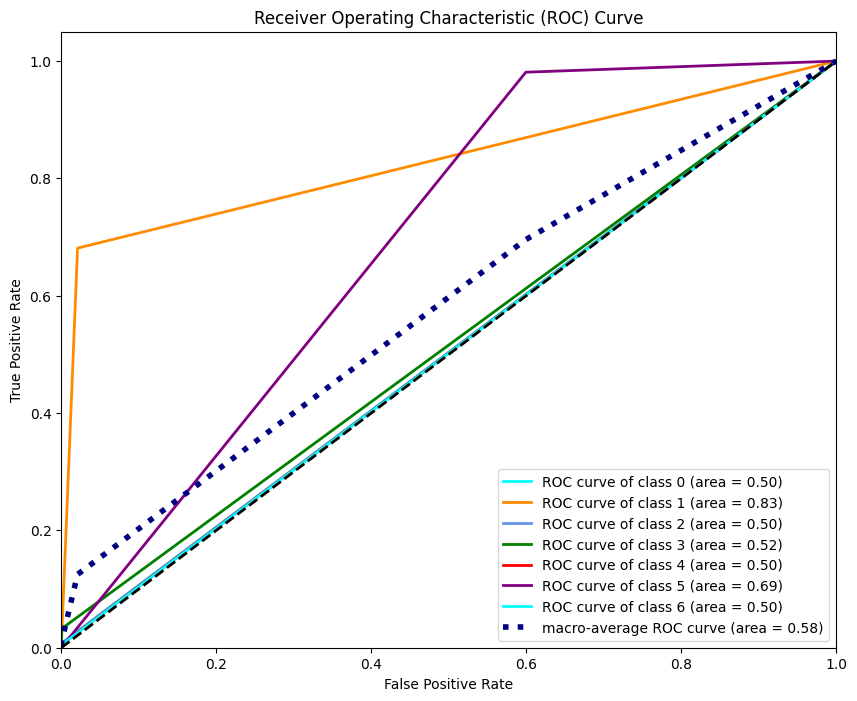

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))


mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])


mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle=':', linewidth=4,
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


This is a very high macro precision but we may have overfitted to the validation data. We also wanted to train another gradient boost model that gave high macro precision for the public score. And we will compare the distributions just to somewhat see if we can find out something we can improve. 

In [ ]:
y_pred_lgb= lgbm_model_first.predict(base_learner_val_predictions)
print(classification_report(y_val_for_meta, y_pred_lgb))

macro_precision = precision_score(y_val_for_meta, y_pred_lgb , average='macro')
print(f'Macro Precision Score: {macro_precision:.4f}')

FINALIZING THE MODEL

Preprocess the test data and get the tfidf vectors.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_data = bugs_test_df["summary"]
processed_text_data = text_data.apply(preprocess_text)
text_data = processed_text_data
print(text_data)

0        firefox claim default browser "update-altern -...
1        background html bodi element appli correctli i...
2        mous input break use window showmodaldialog fu...
3        build failur next freetyp version/curr git master
4              html element treat root insid foreignobject
                               ...                        
86089                crash bool isabouttobefinalizedintern
86090    potenti crash graphrat greater khz webrtcaudio...
86091    crash name omit | decltyp js dispatchtracekindtyp
86092    crash xul dll @ x fa | xul dll @ x c ff | mozg...
86093    symbol clang rt asan dynamic-x dll taskclust b...
Name: summary, Length: 86094, dtype: object


In [38]:
X_tfidf_test= tfidf_vectorizer.transform(text_data)


Since we got a %91 macro precision score on our validation data with the first ensemble model, keeping in mind that it can be due overfitting to the validation data we wanted to see if thats the case or not. We also know that since gradient boost models use decision trees, they may be unstable and we may have tuned our hyperparameters just right so we also wanted to see what that model will give as predictions. We can compare the 3 model's output by distributions and submit for evaluation. 


Predict with the tuning model:

In [61]:

logreg_pred1_t = log_reg_model.predict(X_tfidf_test)
logreg_pred2_t = log_reg_model_2.predict(X_tfidf_test)

xgb_pred1_t = xgb_model.predict(X_tfidf_test)
xgb_pred2_t = xgb_model_2.predict(X_tfidf_test)

base_learner_predictions_of_test_from_firstBuild = pd.DataFrame({
    'logreg_pred1': logreg_pred1_t,
    'logreg_pred2': logreg_pred2_t,
    'xgb_pred1': xgb_pred1_t,
    'xgb_pred2': xgb_pred2_t
})
print(base_learner_predictions_of_test_from_firstBuild )

       logreg_pred1  logreg_pred2  xgb_pred1  xgb_pred2
0                 5             5          5          5
1                 5             5          5          5
2                 5             5          5          5
3                 5             5          5          5
4                 5             5          5          5
...             ...           ...        ...        ...
86089             1             1          1          1
86090             1             1          1          1
86091             5             5          1          1
86092             1             1          1          1
86093             5             5          5          5

[86094 rows x 4 columns]


In [62]:
y_pred_cb_test_from_firstbuild= catboost_meta.predict(base_learner_predictions_of_test_from_firstBuild)

Now, we will build the 2 models again with all data.

In [39]:
#now transform training data again using all training data. 

text_data_fin_train =bugs_train_df["summary_preprocessed"]

X_tfidf_train_fin= tfidf_vectorizer.transform(text_data_fin_train )



In [40]:
labels_fin = bugs_train_df["severity_encoded"]
print(labels_fin)

0         5
1         1
2         3
3         5
4         1
         ..
159993    5
159994    5
159995    1
159996    1
159997    5
Name: severity_encoded, Length: 159998, dtype: int32


In [41]:
#train all models again with all training data :

#xgb1:

params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 750,
    'subsample': 0.8
}

xgb_model_fin1= xgb.XGBClassifier(
    colsample_bytree=params['colsample_bytree'],
    learning_rate=params['learning_rate'],
    max_depth=params['max_depth'],
    n_estimators=params['n_estimators'],
    subsample=params['subsample'],

)

xgb_model_fin1.fit(X_tfidf_train_fin,labels_fin)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=750, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [42]:
#xbg2:

params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 500,
    'subsample': 0.8
}

xgb_model_fin2 = xgb.XGBClassifier(
    colsample_bytree=params['colsample_bytree'],
    learning_rate=params['learning_rate'],
    max_depth=params['max_depth'],
    n_estimators=params['n_estimators'],
    subsample=params['subsample'],
 
)

class_weights={0: 1, 1:3, 2:1, 3:1, 4:1, 5:4, 6:1 }
sample_weights = np.array([class_weights[class_label] for class_label in labels_fin])
xgb_model_fin2.fit(X_tfidf_train_fin,labels_fin, sample_weight= sample_weights )


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [43]:

#lr1:
class_weight_lr1 = {0: 3, 1: 5, 2:2, 3:1, 4:1, 5:4, 6:5}  
log_reg_model_fin1 = LogisticRegression(class_weight=class_weight_lr1, random_state=42, max_iter= 70)
log_reg_model_fin1.fit(X_tfidf_train_fin,labels_fin)

#lr2:
class_weight_lr2 = {0: 4, 1: 5, 2:2, 3:1, 4:1, 5:1, 6:8} 
class_weight_lr2[5] = 4 
log_reg_model_fin2= LogisticRegression(class_weight=class_weight_lr2, random_state=42, max_iter= 200)
log_reg_model_fin2.fit(X_tfidf_train_fin,labels_fin)

C:\Users\idilk\OneDrive\Masaüstü\cs412_kaggle\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 4, 1: 5, 2: 2, 3: 1, 4: 1, 5: 4, 6: 8},
                   max_iter=200, random_state=42)

In [44]:
#now prediict training set with each base model: 
logreg_pred1 = log_reg_model_fin1.predict(X_tfidf_train_fin)
logreg_pred2 = log_reg_model_fin2.predict(X_tfidf_train_fin)

xgb_pred1 = xgb_model_fin1.predict(X_tfidf_train_fin)
xgb_pred2 = xgb_model_fin2.predict(X_tfidf_train_fin) 
#lgm_pred = lgbm_model.predict(X_tfidf_train_fin)

base_learner_predictions_train = pd.DataFrame({
    'logreg_pred1': logreg_pred1,
    'logreg_pred2': logreg_pred2,
    'xgb_pred1': xgb_pred1,
    'xgb_pred2': xgb_pred2,
    #"lgm_pred":lgm_pred
})
print(base_learner_predictions_train)

        logreg_pred1  logreg_pred2  xgb_pred1  xgb_pred2
0                  5             5          5          5
1                  1             1          1          1
2                  5             5          5          5
3                  5             5          5          5
4                  1             1          1          1
...              ...           ...        ...        ...
159993             5             5          5          5
159994             5             5          5          5
159995             5             5          1          1
159996             5             5          5          5
159997             5             5          5          5

[159998 rows x 4 columns]


In [45]:
from catboost import CatBoostClassifier

#train catboost
catboost_meta_fin = CatBoostClassifier(iterations=1000,
                          learning_rate=0.005,
                          depth=10,
                          l2_leaf_reg = 2,
                          loss_function = "MultiClass",
                          class_weights = [1,2,1,1,2,4,1]
 
                          )

catboost_meta_fin.fit(base_learner_predictions_train, labels_fin)

0:	learn: 1.9201497	total: 86.8ms	remaining: 1m 26s
1:	learn: 1.8952357	total: 172ms	remaining: 1m 25s
2:	learn: 1.8711122	total: 252ms	remaining: 1m 23s
3:	learn: 1.8477429	total: 292ms	remaining: 1m 12s
4:	learn: 1.8250644	total: 362ms	remaining: 1m 11s
5:	learn: 1.8030738	total: 398ms	remaining: 1m 5s
6:	learn: 1.7816908	total: 502ms	remaining: 1m 11s
7:	learn: 1.7609118	total: 584ms	remaining: 1m 12s
8:	learn: 1.7407006	total: 636ms	remaining: 1m 10s
9:	learn: 1.7210387	total: 674ms	remaining: 1m 6s
10:	learn: 1.7019034	total: 708ms	remaining: 1m 3s
11:	learn: 1.6832369	total: 810ms	remaining: 1m 6s
12:	learn: 1.6650461	total: 853ms	remaining: 1m 4s
13:	learn: 1.6472976	total: 941ms	remaining: 1m 6s
14:	learn: 1.6299804	total: 988ms	remaining: 1m 4s
15:	learn: 1.6130623	total: 1.1s	remaining: 1m 7s
16:	learn: 1.5965532	total: 1.14s	remaining: 1m 5s
17:	learn: 1.5804139	total: 1.22s	remaining: 1m 6s
18:	learn: 1.5646385	total: 1.32s	remaining: 1m 8s
19:	learn: 1.5492075	total: 1.43s

USE MODELS TO PREDICT FOR TEST

In [46]:
#now try with each base model: 
logreg_pred1 = log_reg_model_fin1.predict(X_tfidf_test)
logreg_pred2 = log_reg_model_fin2.predict(X_tfidf_test)

xgb_pred1 = xgb_model_fin1.predict(X_tfidf_test)
xgb_pred2 = xgb_model_fin2.predict(X_tfidf_test)

base_learner_predictions_test = pd.DataFrame({
    'logreg_pred1': logreg_pred1,
    'logreg_pred2': logreg_pred2,
    'xgb_pred1': xgb_pred1,
    'xgb_pred2': xgb_pred2,
    #'lgm_pred' : pred
})
print(base_learner_predictions_test)

       logreg_pred1  logreg_pred2  xgb_pred1  xgb_pred2
0                 5             5          5          5
1                 5             5          5          5
2                 5             5          5          5
3                 5             5          5          5
4                 5             5          5          5
...             ...           ...        ...        ...
86089             1             1          1          1
86090             5             5          1          1
86091             5             5          1          1
86092             1             1          1          1
86093             5             5          5          5

[86094 rows x 4 columns]


In [57]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
class_weights={0: 1, 1:3, 2:1, 3:1, 4:1, 5:4, 6:1 }
params = {
    'boosting_type': 'dart', 
    'num_leaves': 50,         
    'max_depth': -1,           
    'learning_rate': 0.1,      
    'n_estimators': 500,       
    'objective': 'multiclass',   
    
    'metric': 'multi_error' ,  
    'class_weight': class_weights 
}

lgbm_model = LGBMClassifier(**params)
lgbm_model.fit(X_tfidf_train_fin,labels_fin)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.558778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211687
[LightGBM] [Info] Number of data points in the train set: 159998, number of used features: 2855
[LightGBM] [Info] Start training from score -6.709402
[LightGBM] [Info] Start training from score -2.329267
[LightGBM] [Info] Start training from score -4.866658
[LightGBM] [Info] Start training from score -4.553600
[LightGBM] [Info] Start training from score -5.222107
[LightGBM] [Info] Start training from score -0.132737
[LightGBM] [Info] Start training from score -6.168505


LGBMClassifier(boosting_type='dart',
               class_weight={0: 1, 1: 3, 2: 1, 3: 1, 4: 1, 5: 4, 6: 1},
               metric='multi_error', n_estimators=500, num_leaves=50,
               objective='multiclass')

Predictions:
1- lgbm classifier's results 
**we wanted to inclue it since it is one of our models that for that time, it previously performed a %59 on kaggle public score. We did another hyperparameter tuning and got %60 but this one is faster to train and will give similar results, for the time being. 
However out catboost ensemble model works better on the privte score achieving a score of  %67 macro precision.**
2- final catboost model's  results
3- non-final catboost model's results

In [58]:
pred_lgm= lgbm_model.predict(X_tfidf_test)

In [59]:

pred = pred_lgm

print(pred)
unique, counts = np.unique(pred, return_counts=True)
pred_counts = dict(zip(unique, counts))

print(pred_counts)


[5 5 5 ... 1 1 5]
{0: 8, 1: 7251, 2: 27, 3: 84, 5: 78721, 6: 3}


In [60]:
test_pred_cb_fin= catboost_meta_fin.predict(base_learner_predictions_test)

predictions_vector = test_pred_cb_fin.flatten()

pred = predictions_vector

print(pred)
unique, counts = np.unique(pred, return_counts=True)
pred_counts = dict(zip(unique, counts))

print(pred_counts)

[5 5 5 ... 5 1 5]
{0: 1, 1: 6477, 2: 6, 3: 84, 5: 79526}


In [63]:

predictions_vector_first = y_pred_cb_test_from_firstbuild.flatten()

pred = predictions_vector_first

print(pred)
unique, counts = np.unique(pred, return_counts=True)
pred_counts = dict(zip(unique, counts))

print(pred_counts)

[5 5 5 ... 5 1 5]
{0: 1, 1: 6372, 2: 7, 3: 85, 5: 79629}


We see that both of the catboost model predict very similarly. The light gbm model seems to also predict labels of the minority classes that are 0 and 6. We don't know if that's a misclassification or not. Yet we see that all of our models predict the majority classes as majority classes.

In [65]:
import pandas as pd
y_pred = pred_lgm

label_mapping = {0: 'blocker', 1: 'critical', 2: 'enhancement', 3: 'major', 4: 'minor', 5: 'normal', 6: 'trivial'}  # actual mapping

reversed_predictions = [label_mapping[pred] for pred in y_pred]
bug_ids_test = bugs_test_df ['bug id']

predictions_df = pd.DataFrame({'bug_id': bug_ids_test, 'prediction': reversed_predictions})

predictions_df.to_csv('predictions_lighgbm.csv', index=False)


Best final results on the private score: 

In [67]:
import pandas as pd
y_pred = test_pred_cb_fin.flatten()

label_mapping = {0: 'blocker', 1: 'critical', 2: 'enhancement', 3: 'major', 4: 'minor', 5: 'normal', 6: 'trivial'}  # actual mapping

reversed_predictions = [label_mapping[pred] for pred in y_pred]
bug_ids_test = bugs_test_df ['bug id']

predictions_df = pd.DataFrame({'bug_id': bug_ids_test, 'prediction': reversed_predictions})


predictions_df.to_csv('predictions_cb_testfin.csv', index=False)
